# 自然言語処理 ー 感情分析

## 1.　自然言語処理の7ステップ

#### ① 自然言語（文章）を用意
　吾輩は猫である。

#### ② 単語ごとに区切る（形態素解析）
　吾輩　／　は　／　猫　／　で　／　ある　／　。

#### ③ 助詞「「てにをは」などを削除する（データのクレンジング）
　吾輩　／　猫　　　※それ以外は削除

#### ④ 単語を原形（running→run など）に戻す（トークン化）
　今回はなし

#### ⑤ 各語句の頻出度を求める（BoW）
　吾輩：１　猫：1

#### ⑥ 各語句の重み（TF-IDF）を調べ、特徴語を決める
　吾輩：xxx　、猫：xxxx　　　→　特徴語は「猫」

#### ⑦ 他の文章との区別（分類）を行う
　夏目漱石「吾輩は猫である」の特徴語：猫<br>
 　森鴎外「舞姫」の特徴語：姫
  
　どちらかの小説の一文を投入する　→　この小説は「夏目漱石」の小説です

## 2.　IMDbデータセットの取得<br>

今回は、以下のデータセットを使用する。

・[IMDb](http://ai.stanford.edu/~amaas/data/sentiment/)：映画レビューのデータセット

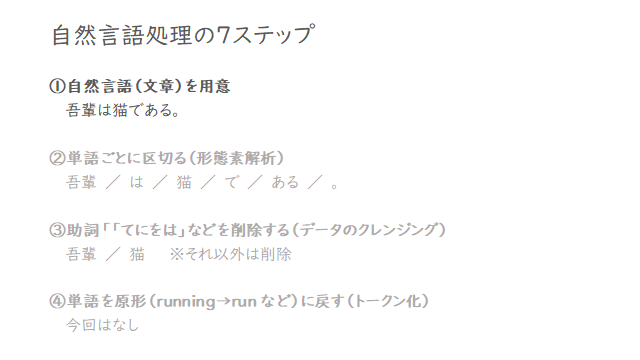

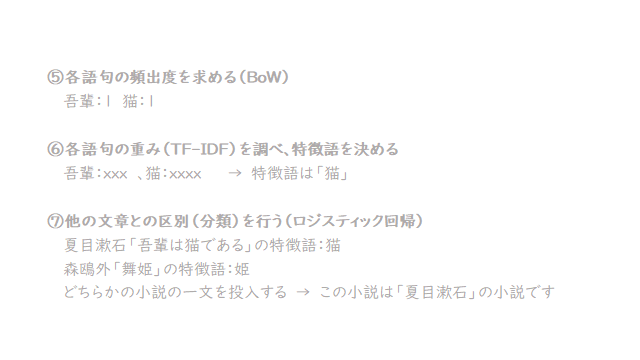

In [ ]:
import os
import re
import sys
import time
import nltk
import optuna
import pyprind
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('../input/movie-datacsv/movie_data.csv')
print(df.shape)

pd.set_option("display.max_colwidth", 150)
df.head(10)

## 3.　BoWベクトル

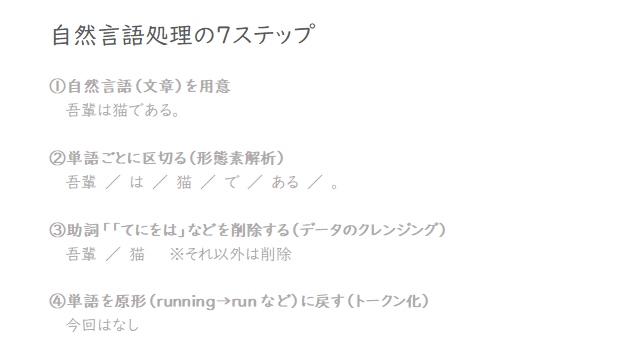

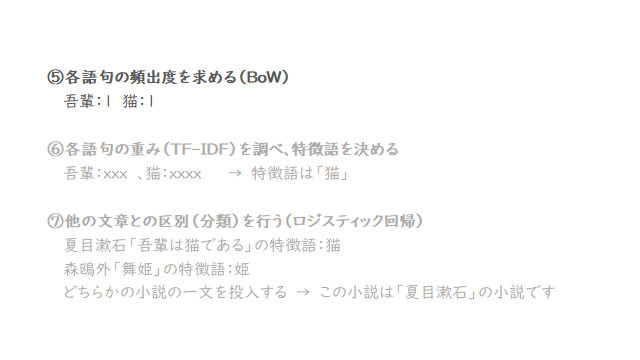

文を数値化（ベクトル化）する方法として、**Bag of Words（BOW）**がある。

### 3.1　単語を特徴ベクトルに変換する

In [ ]:
docs = np.array(['The sun is shining',
                 'The weather is sweet',
                 'The sun is shining, the weather is sweet, and one and one is two'])

scikit-learnに実装されているCountVectorizer()で、BoWベクトルをカウントする。

In [ ]:
count = CountVectorizer()
bag = count.fit_transform(docs)

上記によって、次の3つの文章におけるBoWモデルが構築された。<br>
ここで、各単語に番号（インデックス）を付け、それぞれ確認をする。

In [ ]:
print('単語:インデックス', count.vocabulary_)

3文目の「the」の頻出度を調べてみる。<br>
0から数えるとインデックスは2となり、最後には単語を入れる。

In [ ]:
print('頻出度：', bag.toarray()[2][count.vocabulary_['the']])

次に、特徴ベクトルを出力する。

In [ ]:
pd.DataFrame(bag.toarray())

行は1～3文目、列は各単語のインデックス番号を前提に表示されている。<br>
分かりやすいように、表示し直す。

In [ ]:
pd.DataFrame(bag.toarray(),
             index=['The sun is shining',
                    'The weather is sweet',
                    'The sun is shining, the weather is sweet, and one and one is two'],
             columns=['and', 'is', 'one', 'shining', 'sun', 'sweet', 'the', 'two', 'weather'])

## 4.　TF-IDFを使って単語の関連性を評価する

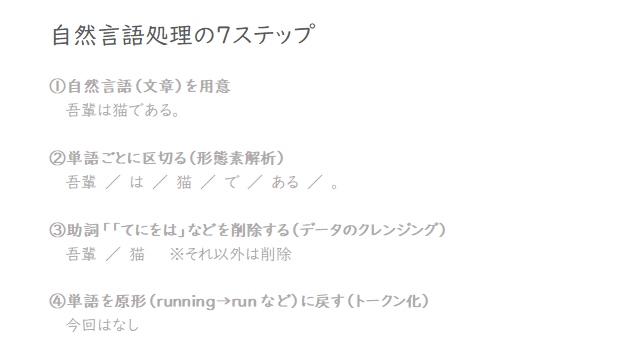

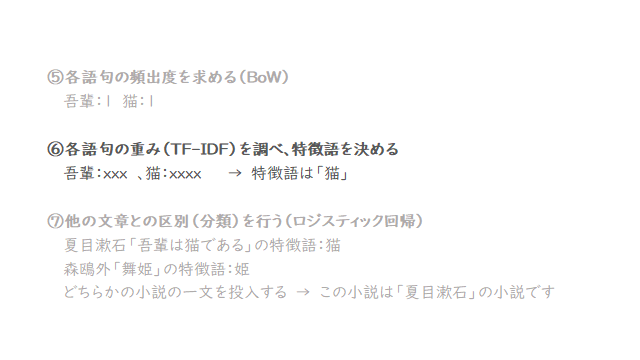

$\rm{TF}$：対象の単語が、ある文書中にどれだけの頻度で出現しているか（頻度）<br>
$\rm{IDF}$：対象の単語が含まれる文が、文章全体にどれだけの頻度で出現していないか（珍しさ）<br>
$\rm{TF-IDF}$：Term Frequency – Inverse Document Frequency の略（重みづけの指標）

例えば、小説一冊が、下記で構成されているとする。

・$D$ 個の文<br>
・$N$ 個の単語

小説に単語 $x$ が $n$ 回現れるならば
$$\begin{eqnarray}
{\rm TF}=\frac{n}{N}
\end{eqnarray}$$
小説に単語 $x$ を含む文が $d$ 個あるならば
$$\begin{eqnarray}
{\rm IDF}=-\log_{10}\frac{d}{D}=\log_{10}\frac{D}{d}
\end{eqnarray}$$
よって、次のように求まる。
$$\begin{eqnarray}
{\rm TF-IDF}=\frac{n}{N}\log_{10}\frac{D}{d}
\end{eqnarray}$$

例題

太宰治の作品「一歩前進二歩退却」から一部を抜粋したものである。<br>
TF-IDFを求めなさい。

-----

　作家は、いよいよ窮屈である。何せ、眼光紙背に徹する読者ばかりを<br>
相手にしているのだから、うっかりできない。あんまり緊張して、ついには<br>
机のまえに端座したまま、そのまま、沈黙は金、という格言を底知れず肯定している。<br>
そんなあわれな作家さえ出て来ぬともかぎらない。<br>
　謙譲を、作家のみ要求し、作家は大いに恐縮し、卑屈なほどへりくだって<br>
そうして読者は旦那である。作家の私生活、底の底まで剥ごうとする。<br>
失敗である。安売りにしていいのは作品である。作家の人間までを売ってはいない。<br>
謙譲は、読者にこそ之を要求したい。

-----

下記をカウントした。<br>
<br>
単語数 $N$：150<br>
単語の種類：48<br>
文数 $D$：10

次に「作家」という単語 $x$ に着目する。

出現回数 $n$：6<br>
含まれる文数 $d$：5

よって、次のように求まる。<br>

$$\begin{eqnarray}
{\rm TF}=\frac{n}{N}=\frac{6}{150}=0.04
\end{eqnarray}$$

$$\begin{eqnarray}
{\rm IDF}=\log_{10}\frac{D}{d}=\log_{10}\frac{10}{5}=0.301
\end{eqnarray}$$

$$\begin{eqnarray}
{\rm TF-IDF}=0.0120
\end{eqnarray}$$<br>
<br>
実際の自然言語処理では、これを48種類の単語すべてに行っていく。

### 4.1　scikit-learnでTF-IDFを実装する

scikit-learnには、TfidTransformerという関数が実装されている。<br>
これは、fit_transformメソッドのCountVectorizerから「生の単語の出現頻度」を入力として受け取り、TF-IDFに変換する。

In [ ]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
tfidf_vec = tfidf.fit_transform(count.fit_transform(docs)).toarray()

pd.DataFrame(tfidf_vec.round(2))

smooth_idf：Truleがデフォルト<br>
use_idf：idf()の使用有無（idf()関数による重み付けを行うかどうか）<br>
norm：正則化の指定（デフォルトはなし、'l2'指定で単語ベクトルの長さが1になるよう正規化）<br>
toarray()：行列出力

それぞれの文や単語とも紐づけて可視化すると、以下のようになる。

In [ ]:
tfidf_df = pd.DataFrame(tfidf_vec.round(2),
                        index=['The sun is shining',
                               'The weather is sweet',
                               'The sun is shining, the weather is sweet, and one and one is two'],
                        columns=['and', 'is', 'one', 'shining', 'sun', 'sweet', 'the', 'two', 'weather'])

tfidf_df.head()

「is」は3つの文章で使われているため、特徴語ではなく、どの文法に必要な語と判断される。<br>
TF-IDFが（0.45）とそれほど大きくないことからも考えられる。

一方で、「one」は3つ目の文章だけで2回使用されているので<br>
TF-IDFは（0.5）と少しだけ大きくなっている。

## 5.　クレンジング

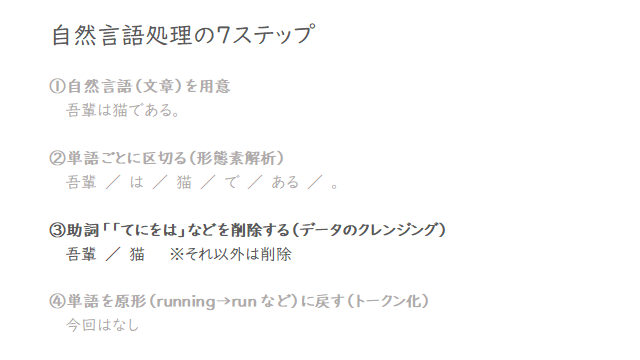

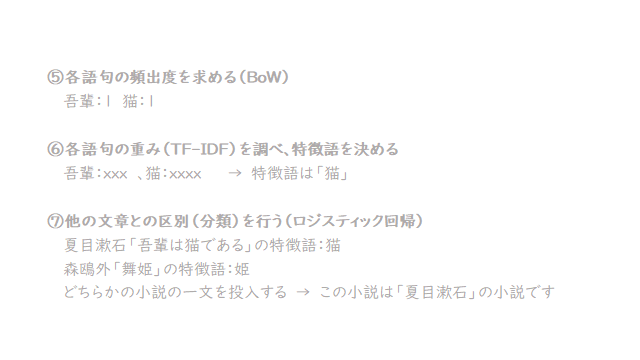

まず、映画レビューデータセットの1つ目の文章から、最後の50文字を出力する。

In [ ]:
df.loc[0, 'review'][-50:]

出力結果を見てみると、不要な句読点や非英字文字が多い。<br>
感情分析に役に立ちそうな顔文字要素のある記号「　：)　」のみ残し、それ以外はすべて削除する。<br>
その際、今回はPythonの正規表現ライブラリを使用する。

In [ ]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

re.sub：正規表現で指定した文字列を置換する<br>
str.lower(): すべての文字を小文字に変換

2行目：正規表現（<[^>]*>）を使用し、HTMLマークアップを削除<br>
3行目：顔文字を検索し、emoticonsに格納<br>
4行目：正規表現[\w]+を使って単語の一部でない文字を削除、小文字に変換し、emoticonsを加え、顔文字内の「-」を消去

In [ ]:
print('変換前:', df.loc[0, 'review'][-50:])
print('変換後:', preprocessor(df.loc[0, 'review'][-50:]))

In [ ]:
print(preprocessor("</a>This :) is :( a test :-)!"))
print(preprocessor("!\/.i like ;.::python/:]/];/]"))
print(preprocessor('machine\::lear\[:::nig];@[/]'))

再度、映画レビューデータセットの1行目を表示する。

In [ ]:
print(df.shape)
df.head(10)

これに、先ほど作成したpreprocessor関数を適用する。<br>
出力結果を確認すると、余計な文字や記号がなくなっていることが分かる。

In [ ]:
df['review'] = df['review'].apply(preprocessor)
df.head(10)

## 6.　トークン化

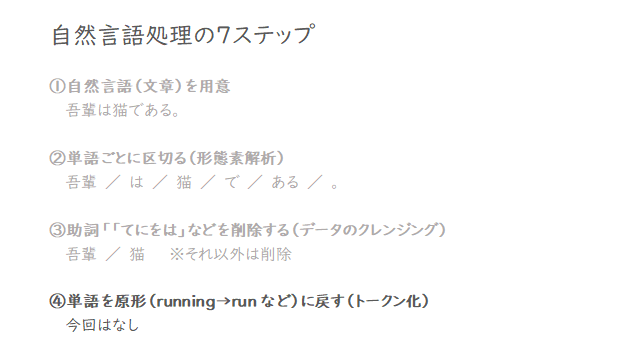

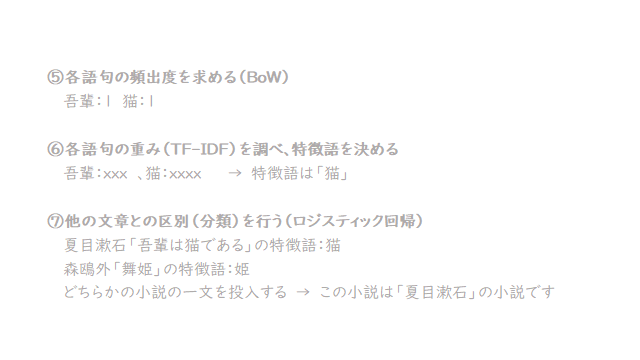

トークン化：文章を個々の単語に分割したり、変換したりすること<br>
ワードステミング：単語を原形に変換すること　（例）running →　run　など

ワードステミングは、PorterStemmerによって開発され、Porter stemmingアルゴリズムとも呼ばれる。<br>
NLTKライブラリに実装されている。

In [ ]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

split()：文字を空白で分割<br>
tokenizer_porter(text)：split()で分割した単語をfor文で1個ずつ取り出し、ワードステミングを実行

ここで、トークン化とトークン化＋ワードワードステミングの結果を比較する。

In [ ]:
print(tokenizer('runners like running and thus they run'))
print(tokenizer_porter('runners like running and thus they run'))

また、ストップワードの除去も行う。<br>
こちらも、NLTKライブラリで実行することができる。

まず、nltkに登録されているストップワードをダウンロードする。<br>
その後、ストップワードでないものにtokenizer_porter()を適用し、単語を抽出する。

In [ ]:
nltk.download('stopwords')

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:] if w not in stop]

## 7.　自然言語処理のデモンストレーション

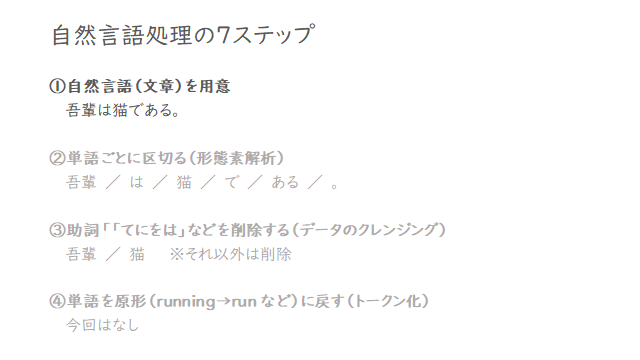

機械学習モデルを用いて、下記に分類する。

1：肯定的なレビュー（面白かった など）<br>
0：否定的なレビュー（つまなかった など）

まず、クレンジングしたテキストのDataframeを、訓練データとテストデータに分割する。

In [ ]:
train = df[:25000]

print(train.shape)
train.head(10)

In [ ]:
train.loc[0, 'review']

In [ ]:
test = df[25000:25010]

print(test.shape)
test.head(10)

In [ ]:
test_review = test['review']

In [ ]:
data = pd.concat([train, test], axis=0)

print(data.shape)
data.tail()

In [ ]:
X = data['review']
y = data['sentiment']

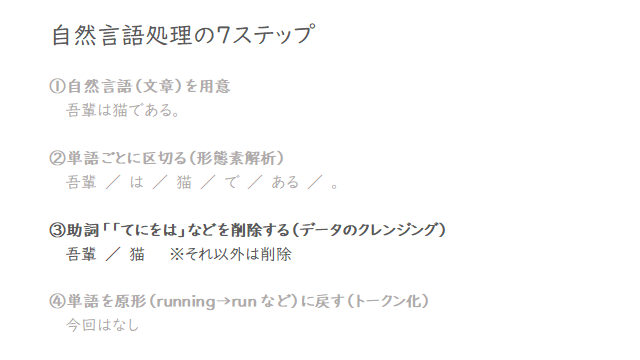

In [ ]:
X = X.apply(lambda x: preprocessor(x))

print(X.shape)
pd.DataFrame(X).head()

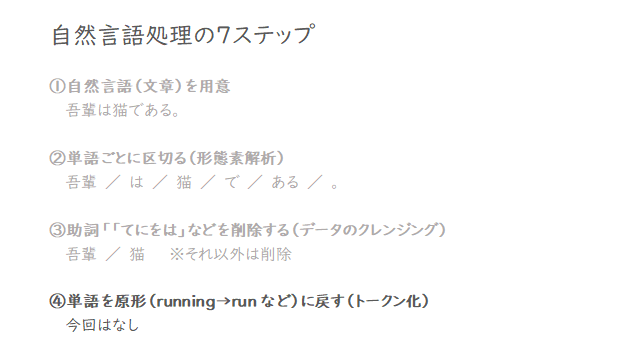

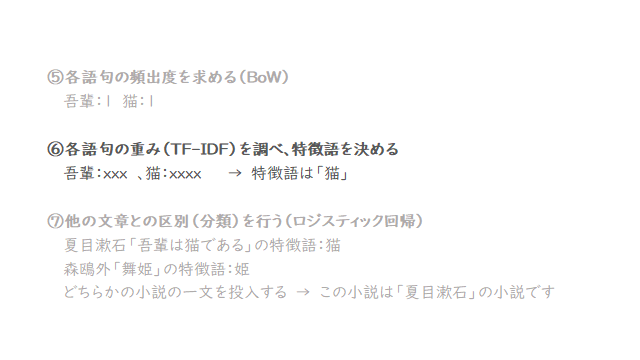

In [ ]:
tv = TfidfVectorizer(stop_words='english')
X = tv.fit_transform(X)

# tv = TfidfVectorizer(tokenizer=tokenizer_porter, stop_words='english')

In [ ]:
X_train = X[:25000]
y_train = y[:25000]
X_test = X[25000:]
y_test = y[25000:]

print(X_test.shape)

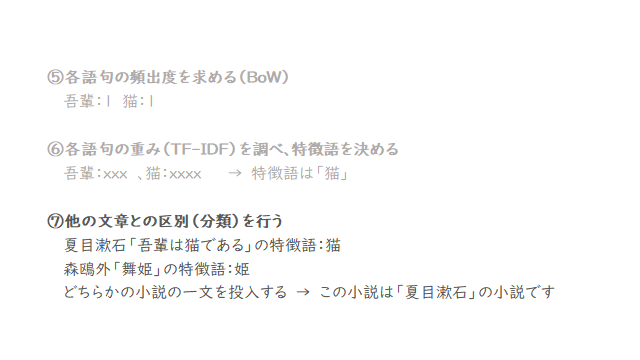

In [ ]:
'''
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
params = study.best_params
print(params)
'''

In [ ]:
params = {'num_leaves': 4,
          'n_estimators': 176,
          'learning_rate': 0.7640072433410199,
          'max_depth': 6,
          'min_child_samples': 476,
          'min_data_in_leaf': 9,
          'bagging_freq': 3,
          'bagging_fraction': 0.8248507115994583,
          'feature_fraction': 0.8322179797272392,
          'subsample': 0.4057420045273623,
          'colsample_bytree': 0.12450239286883741,
          'random_state': 666}

In [ ]:
cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

In [ ]:
y_pred = cls.predict(X_test)
print(X_test.shape)
print(y_pred.shape)

In [ ]:
df = pd.DataFrame(test_review, columns=['review'])
df['answer'] = y_test
df['prediction'] = y_pred

df.head(10)

In [ ]:
print('精度:', accuracy_score(y_test, y_pred)*100, '%')